In [22]:
#Package imports
import logging
import os
import pytz
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from financial_modelling.modelling.SVIModel import SVIModel as svi
from financial_modelling.data_acquisition.database_fetcher import DatabaseFetcher as dbf
from financial_modelling.data_pre_processing.IVPreprocessor import IVPreprocessor as ivp
from financial_modelling.data_acquisition.list_of_files_fetcher import ListOfFilesFetcher as loff
import pandas as pd
index_of_quote_date = 10
index_of_expiration_date = 21

We need to get first the fitted dates from the folder where the fitted data is present

In [23]:
#List of fitted SVI parameters
folder = r"E:\OutputParamsFiles\OutputFiles"
loff = loff()
loff.fetch(folder)
loff.get_unixtimestamp()
list_of_fitted_dates = loff.list_of_dates
date = list_of_fitted_dates[index_of_quote_date]

In [24]:
#Function get_unixtimestamp_readable for logging purposes
def get_unixtimestamp_readable(unixtimestamp):
    logging.info(datetime.fromtimestamp(unixtimestamp, pytz.timezone("US/Eastern")).strftime('%d-%m-%Y %H:%M'))

Need to implement a function that give the corresponding data in the database.

I. The database connection string

In [25]:
#Connection configuration
DB_CONFIG = {
    'server': 'DESKTOP-DK79R4I',  # Your server name
    'database': 'DataMining',     # Your database name
}

#Define pyodbc-compatible connection string
connection_string = (
        f"DRIVER={{SQL Server}};"
        f"SERVER={DB_CONFIG['server']};"
        f"DATABASE={DB_CONFIG['database']};"
        f"Trusted_Connection=yes;"
)

#Define the query string
query = f"""
        SELECT TOP(6302) *
        FROM [DataMining].[dbo].[OptionData]
        WHERE [QUOTE_UNIXTIME] = '{date}'
        """
database_fetcher = dbf(connection_string)
raw_data = database_fetcher.fetch(query)
database_fetcher.close()

INFO:root:DatabaseFetcher initialized with DRIVER={SQL Server};SERVER=DESKTOP-DK79R4I;DATABASE=DataMining;Trusted_Connection=yes;
c:\users\paula\onedrive\documents\financial modelling package\financial_modelling\data_acquisition\database_fetcher.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.conn)


pyodbc connection established in 0.00 ms
Query executed in 0.2466 seconds
pyodbc connection closed.


Need to extract the needed data from raw_data

In [26]:
#Preprocessor preprocessing rawa data
processed_data = ivp(raw_data).preprocess()
expiry = processed_data["EXPIRE_UNIX"].unique()[index_of_expiration_date]
processed_data = processed_data[processed_data["EXPIRE_UNIX"] == expiry]
log_moneyness = np.array(processed_data["Log_Moneyness"])

Now we get the fitted model estimated on the raw requested data from the the database

In [27]:
#Get the fitted SVI parameters
def get_the_fitted_params_file(date, folder):
    file_path = os.path.join(folder, f"output_{date}.csv")
    fitted_params_file = pd.read_csv(file_path, sep = ",")
    return fitted_params_file
#Get the fitted SVI parameters & Maturity
def get_the_fitted_params(dataframe, expiry):
    fitted_params_file = get_the_fitted_params_file(date, folder)
    expriry_specific_params = fitted_params_file[fitted_params_file["EXPIRE_DATE"] == expiry]
    maturity = np.array(expriry_specific_params['Maturity'])
    params = {"a":expriry_specific_params["a"],
            "b":expriry_specific_params["b"],
            "rho":expriry_specific_params["rho"],
            "m":expriry_specific_params["m"],
            "sigma":expriry_specific_params["sigma"]}
    for i in params.keys():
        params[i] = np.array(params[i])
    return params, maturity

params, maturity = get_the_fitted_params(processed_data, expiry)
svi_values = (1/np.sqrt(maturity))*np.sqrt(svi().svi(log_moneyness, params["a"], params["b"], params["rho"], params["m"], params["sigma"]))

Plot the fitted model data against the raw data IV

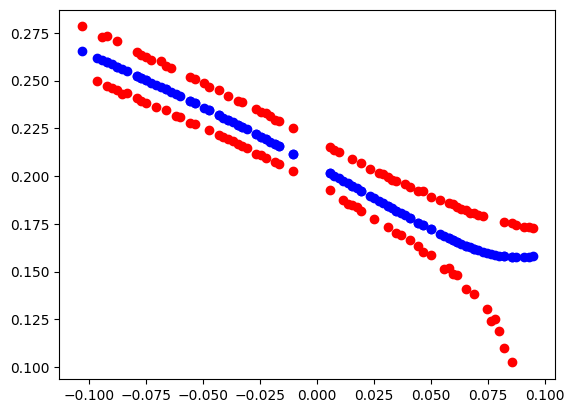

In [28]:
plt.scatter(log_moneyness, svi_values, color = "blue", label = "Fitted IV Model")
plt.scatter(log_moneyness, processed_data["Implied_Volatility"], color = "red", label = "Market IV")
plt.show()